# Modèle continu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker

In [14]:

# Chargement des données du virus

dfV = pd.read_csv('Virus.csv', header=None)
dataV = dfV[1].values
timeV = dfV[0].values


def V_interp(t):
    t = np.asarray(t)
    return np.interp(t, timeV, dataV, left=dataV[0], right=0)


In [15]:
def mod_cont(Y, t, params):
    N, A, M = Y
    a = 1
    sigma_M = 1e-5
    al, p, r, K = params  # paramètres : alpha, p, r, K
    Vt = V_interp(t)
    denom = K + Vt
    # Pour éviter une division par zéro, on définit ft = 0 si denom == 0
    ft = Vt / denom if np.all(denom) != 0 else 0
    
    dN = -a * ft * N
    dA = a * ft * (N + M) + p * ft * A - (1 - ft) * (r + al) * A
    dM = (1 - ft) * r * A - a * ft * M - sigma_M * M
    return np.array([dN, dA, dM])


In [16]:

# Implémentation de la méthode du point milieu
def midpoint_method(f, y0, params, h, T):
    
    t_val = np.arange(0, T + h, h)
    Y = np.zeros((len(t_val), len(y0)))
    Y[0] = y0
    for i in range(len(t_val) - 1):
        k1 = f(Y[i], t_val[i], params)
        Y_mid = Y[i] + (h/2) * k1
        k2 = f(Y_mid, t_val[i] + h/2, params)
        Y[i + 1] = Y[i] + h * k2
    return t_val, Y


In [17]:
# Simulation du modèle avec la méthode du point milieu

def simulate_continu(params):
    # Conditions initiales
    N0, A0, M0 = 60, 0, 0
    Y0 = [N0, A0, M0]
    h = 0.1
    T = 50
    t_val, sol = midpoint_method(mod_cont, Y0, params, h, T)
    N = np.clip(sol[:, 0], 0, None)
    A = np.clip(sol[:, 1], 0, None)
    M = np.clip(sol[:, 2], 0, None)
    return N + A + M, N, A, M, t_val


In [18]:
# Fonction d'erreur avec interpolation
def erreur_continu(params, time, data):
    sim, _, _, _, t_val = simulate_continu(params)
    # Interpolation de la solution simulée aux temps de mesure
    interp_fun = interp1d(t_val, sim, kind='linear', fill_value="extrapolate")
    sim_interp = interp_fun(time)
    sim_interp = np.maximum(sim_interp, 1e-8)
    data = np.maximum(data, 1e-8)
    return np.log1p(data) - np.log1p(sim_interp)



`ftol` termination condition is satisfied.
Function evaluations 66, initial cost 1.3445e+02, final cost 1.6872e+00, first-order optimality 4.75e-04.
Epitope: NP118
Meilleurs paramètres : [5.68681242e-01 3.09643965e+00 1.65702999e-02 2.08881483e+05]
SSR = 3.3743417059297953


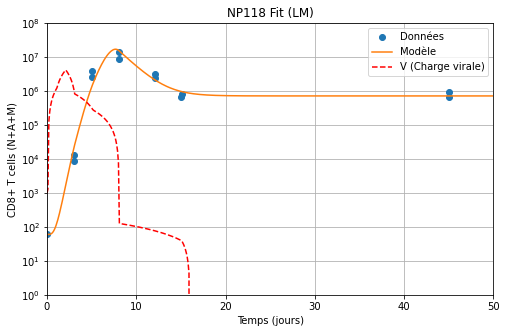

Paramètres optimisés: [5.68681242e-01 3.09643965e+00 1.65702999e-02 2.08881483e+05]
SSR: 3.3743417059297953


In [19]:
def fit_and_plot_lm(epitope_name, csv_path, initial_params):
    try:
        df = pd.read_csv(csv_path, header=None)
    except FileNotFoundError:
        print(f"Fichier {csv_path} introuvable. Fin de la fonction.")
        return None, None
    
    time = df[0].values
    data = df[1].values
    
    # Insertion du point initial si nécessaire
    time = np.insert(time, 0, 0)
    data = np.insert(data, 0, 60)
    
    # Ajustement par moindres carrés
    result = least_squares(erreur_continu, initial_params, args=(time, data), method='lm', verbose=2)
    best_params = result.x



    # Simulation avec la grille d'intégration utilisée (t_val)
    pred_total, _, _, _, t_val = simulate_continu(best_params)


    # Interpolation de la solution simulée aux temps de mesure pour le calcul du SSR
    from scipy.interpolate import interp1d
    interp_fun = interp1d(t_val, pred_total, kind='linear', fill_value="extrapolate")
    pred_interp = interp_fun(time)
    
    safe_pred = np.maximum(pred_interp, 1e-8)
    data_safe = np.maximum(data, 1e-8)
    ssr = np.sum((np.log1p(data_safe) - np.log1p(safe_pred))**2)
    
    print(f"Epitope: {epitope_name}")
    print("Meilleurs paramètres :", best_params)
    print("SSR =", ssr)
    
    # Pour l'affichage, utilisons la grille d'intégration t_val (de taille 501)
    plt.figure(figsize=(8,5))
    plt.plot(time, data, 'o', label='Données')
    plt.plot(t_val, pred_total, '-', label='Modèle')
    plt.plot(t_val, V_interp(t_val), label='V (Charge virale)', color='red', linestyle='--')
    plt.title(f'{epitope_name} Fit (LM)')
    plt.xlabel("Temps (jours)")
    plt.ylabel("CD8+ T cells (N+A+M)")
    plt.legend()
    plt.yscale('log', base=10)
    plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    plt.ylim(1e0, 1e8)
    plt.xlim(0,50)
    plt.grid(True)
    plt.show()
    
    return best_params, ssr

initial_np118 = [0.1, 1, 0.01, 10000]
best_params, ssr_val = fit_and_plot_lm("NP118", 'Fig2NP118_Mesure.csv', initial_np118)
print("Paramètres optimisés:", best_params)
print("SSR:", ssr_val)




# Epitope GP283

`ftol` termination condition is satisfied.
Function evaluations 76, initial cost 5.4361e+01, final cost 5.4010e+00, first-order optimality 3.36e-03.
Epitope: GP283
Meilleurs paramètres : [4.49389718e-01 2.34633894e+00 1.45915247e-02 1.74905479e+05]
SSR = 10.802009548446321


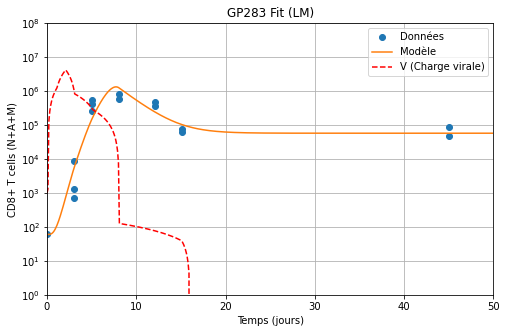

Paramètres optimisés: [4.49389718e-01 2.34633894e+00 1.45915247e-02 1.74905479e+05]
SSR: 10.802009548446321


In [20]:


initial_gp283 = [0.1, 1, 0.01, 10000]
best_params, ssr_val = fit_and_plot_lm("GP283", 'Fig2GP283_Mesure.csv', initial_gp283)
print("Paramètres optimisés:", best_params)
print("SSR:", ssr_val)




# ESTIMATION DES PRAMETRES SIMULTANEMENT (ESTIMATION DE K1 ET K2)

In [9]:

# Charger les données
csv_path_118 = 'Fig2NP118_Mesure.csv'
csv_path_283 = 'Fig2GP283_Mesure.csv'

df_NP = pd.read_csv(csv_path_118, header=None)
df_GP= pd.read_csv(csv_path_283, header=None)


# Chargement des données NP118 et GP283

df_NP = pd.read_csv('Fig2NP118_Mesure.csv', header=None)
df_GP = pd.read_csv('Fig2GP283_Mesure.csv', header=None)
time_NP, data_NP = df_NP[0].values, df_NP[1].values
time_GP, data_GP = df_GP[0].values, df_GP[1].values
time_NP = np.insert(time_NP, 0, 0)
data_NP = np.insert(data_NP, 0, 60)
time_GP = np.insert(time_GP, 0, 0)
data_GP = np.insert(data_GP, 0, 60)

In [26]:
def mod_cont(Y, t, params, k):
    N, A, M = Y
    a = 1
    sigma_M = 1e-5
    al, p, r = params  # paramètres : alpha, p, r
    Vt = V_interp(t)
    denom = k + Vt
    ft = Vt / denom if np.all(denom) != 0 else 0
    dN = -a * ft * N
    dA = a * ft * (N + M) + p * ft * A - (1 - ft) * (r + al) * A
    dM = (1 - ft) * r * A - a * ft * M - sigma_M * M
    return np.array([dN, dA, dM])


In [27]:
def simulate_continu(params, k):
    # Conditions initiales
    N0, A0, M0 = 60, 0, 0
    Y0 = [N0, A0, M0]
    h = 0.1
    T = 50

    

    t_val, sol = midpoint_method(lambda Y, t, params: mod_cont(Y, t, params, k), Y0, params, h, T)
    N = np.clip(sol[:, 0], 0, None)
    A = np.clip(sol[:, 1], 0, None)
    M = np.clip(sol[:, 2], 0, None)
    return N + A + M, N, A, M, t_val

`ftol` termination condition is satisfied.
Function evaluations 225, initial cost 1.7083e+02, final cost 8.2112e+00, first-order optimality 4.66e-03.

--- Résultats ---
Paramètres optimisés communs (alpha, p, r): [0.47769842 2.75768521 0.01617604]
K_NP = 153339.36690259795 K_GP = 282720.75020114257
SSR (NP118) = 4.4100
SSR (GP283) = 12.0124
SSR Total = 16.4224


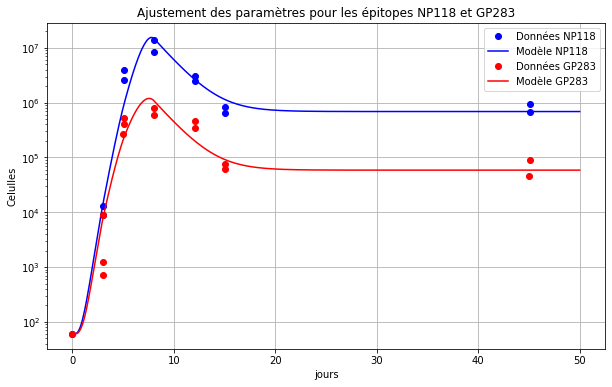

In [28]:

def erreur_continu(x, time_NP, data_NP, time_GP, data_GP):
    params = x[:3]
    K_NP, K_GP = x[3], x[4]
    
    # Simulation pour NP118
    total_NP, _, _, _, t_val_NP = simulate_continu(params, K_NP)
    # Simulation pour GP283
    total_GP, _, _, _, t_val_GP = simulate_continu(params, K_GP)
    
    # Interpolation des résultats simulés aux temps de mesure
    interp_NP = interp1d(t_val_NP, total_NP, kind='linear', fill_value="extrapolate")
    interp_GP = interp1d(t_val_GP, total_GP, kind='linear', fill_value="extrapolate")
    sim_NP = interp_NP(time_NP)
    sim_GP = interp_GP(time_GP)
    
    # Pour éviter les logarithmes de zéro
    sim_NP = np.maximum(sim_NP, 1e-8)
    sim_GP = np.maximum(sim_GP, 1e-8)
    data_NP = np.maximum(data_NP, 1e-8)
    data_GP = np.maximum(data_GP, 1e-8)
    
    # Calcul de l'erreur en domaine logarithmique
    err_NP = np.log1p(data_NP) - np.log1p(sim_NP)
    err_GP = np.log1p(data_GP) - np.log1p(sim_GP)
    
    return np.concatenate([err_NP, err_GP])



# Paramètres:  [alpha, p, r, K_NP, K_GP]
 
x0=[0.1,1,0.01,2000,10000]
 
result = least_squares(erreur_continu, x0, args=(time_NP, data_NP, time_GP, data_GP), method='lm', verbose=2)
 
params_opt = result.x[:3]
K_NP_opt, K_GP_opt = result.x[3], result.x[4]

# Simulation avec les paramètres optimisés pour NP118
sim_NP_opt_total, _, _, _, t_val_NP = simulate_continu(params_opt, K_NP_opt)
# Simulation avec les paramètres optimisés pour GP283
sim_GP_opt_total, _, _, _, t_val_GP = simulate_continu(params_opt, K_GP_opt)

# Interpolation de la solution simulée aux temps expérimentaux pour NP118 et GP283
interp_NP = interp1d(t_val_NP, sim_NP_opt_total, kind='linear', fill_value="extrapolate")
interp_GP = interp1d(t_val_GP, sim_GP_opt_total, kind='linear', fill_value="extrapolate")

sim_NP_interp = interp_NP(time_NP)
sim_GP_interp = interp_GP(time_GP)

# Éviter les problèmes de logarithme de zéro
sim_NP_interp = np.maximum(sim_NP_interp, 1e-8)
sim_GP_interp = np.maximum(sim_GP_interp, 1e-8)
data_NP_safe = np.maximum(data_NP, 1e-8)
data_GP_safe = np.maximum(data_GP, 1e-8)

# Calcul du SSR (Somme des résidus au carré en échelle logarithmique)
SSR_NP = np.sum((np.log1p(data_NP_safe) - np.log1p(sim_NP_interp))**2)
SSR_GP = np.sum((np.log1p(data_GP_safe) - np.log1p(sim_GP_interp))**2)
SSR_total = SSR_NP + SSR_GP



print("\n--- Résultats ---")
print("Paramètres optimisés communs (alpha, p, r):", params_opt)
print("K_NP =", K_NP_opt, "K_GP =", K_GP_opt)
print(f"SSR (NP118) = {SSR_NP:.4f}")
print(f"SSR (GP283) = {SSR_GP:.4f}")
print(f"SSR Total = {SSR_total:.4f}")


# Visualisation 
t_sim = np.linspace(0, 50, 1000)

total_NP, _, _, _, t_val_NP = simulate_continu(params_opt, K_NP_opt)
total_GP, _, _, _, t_val_GP = simulate_continu(params_opt, K_GP_opt)
 

plt.figure(figsize=(10,6))
plt.plot(time_NP, data_NP, 'bo', label='Données NP118')
plt.plot(t_val_NP, total_NP, 'b-', label='Modèle NP118')
plt.plot(time_GP, data_GP, 'ro', label='Données GP283')
plt.plot(t_val_GP, total_GP, 'r-', label='Modèle GP283')
plt.xlabel("jours")
plt.ylabel("Celulles")
plt.title(f"Ajustement des paramètres pour les épitopes NP118 et GP283")
plt.yscale('log', base=10)
plt.legend()
plt.grid(True)
plt.savefig("continu.png", dpi=300, bbox_inches='tight')
plt.show()


**Remarque**  
  Les valeurs des paramètres estimés sont globalement cohérentes avec celles rapportées dans l’article, à l’exception notable du paramètre **K** (concentration antigénique) pour les deux épitopes. 
  
  Cette divergence pourrait s’expliquer par une sensibilité accrue du modèle à ce paramètre spécifique. Malgré cela, les courbes simulées s’ajustent bien aux données expérimentales, traduisant une bonne qualité d’ajustement global.
  
   Dans la suite du code, nous allons imposer des bornes sur certains paramètres afin de mieux contraindre l’optimisation. Pour cela, nous utilisons la méthode **trf (Trust Region Reflective)**, qui prend en charge les contraintes sur les paramètres. Contrairement à la méthode **lm (Levenberg–Marquardt)**, qui est efficace pour les petits problèmes sans contraintes, **trf** est plus flexible et adaptée aux cas où des bornes sont nécessaires.

   

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7469e+02                                    4.46e+03    
       1              2         4.5910e+01      1.29e+02       2.20e+02       2.09e+02    
       2              3         2.5270e+01      2.06e+01       3.50e+04       9.83e+01    
       3              4         1.5898e+01      9.37e+00       3.23e+04       2.30e+01    
       4              5         1.1774e+01      4.12e+00       3.10e+04       2.04e+00    
       5              6         1.0417e+01      1.36e+00       2.31e+04       6.29e-01    
       6              7         1.0139e+01      2.77e-01       7.00e+03       1.07e-01    
       7              8         1.0097e+01      4.21e-02       1.21e+03       7.99e-02    
       8              9         1.0096e+01      9.37e-04       1.75e+01       2.08e-03    
       9             10         1.0096e+01      4.41e-07       1.60e+00       3.53e-05    

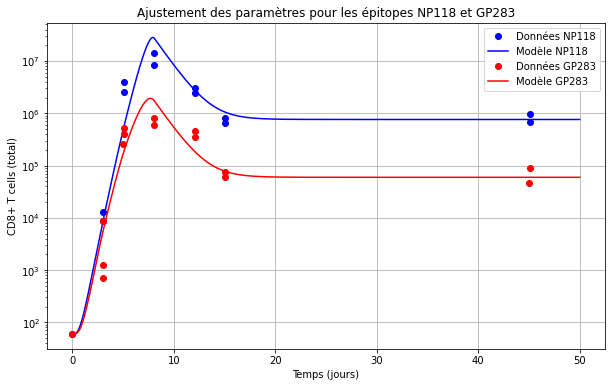

In [29]:


# Optimisation avec bornes 

# Bornes pour [alpha, p, r, K_NP, K_GP]
lower_bounds =[0, 0, 0, 1e3, 1e4]
upper_bounds =[1, 10, 0.1, 50000, 200000]
bounds = (lower_bounds, upper_bounds)
x0=[0.1,1,0.01,3000,10000]
# Estimation initiale aléatoire dans les bornes

#result = least_squares(erreur_continu, x0, args=(time_NP, data_NP, time_GP, data_GP), method='lm', verbose=2)
result = least_squares(erreur_continu, x0, args=(time_NP, data_NP, time_GP, data_GP),
                    bounds=bounds, method='trf', verbose=2)
params_opt = result.x[:3]
K_NP_opt, K_GP_opt = result.x[3], result.x[4]

# Simulation avec les paramètres optimisés pour NP118
sim_NP_opt_total, _, _, _, t_val_NP = simulate_continu(params_opt, K_NP_opt)
# Simulation avec les paramètres optimisés pour GP283
sim_GP_opt_total, _, _, _, t_val_GP = simulate_continu(params_opt, K_GP_opt)

# Interpolation de la solution simulée aux temps expérimentaux pour NP118 et GP283
interp_NP = interp1d(t_val_NP, sim_NP_opt_total, kind='linear', fill_value="extrapolate")
interp_GP = interp1d(t_val_GP, sim_GP_opt_total, kind='linear', fill_value="extrapolate")

sim_NP_interp = interp_NP(time_NP)
sim_GP_interp = interp_GP(time_GP)

# Éviter les problèmes de logarithme de zéro
sim_NP_interp = np.maximum(sim_NP_interp, 1e-8)
sim_GP_interp = np.maximum(sim_GP_interp, 1e-8)
data_NP_safe = np.maximum(data_NP, 1e-8)
data_GP_safe = np.maximum(data_GP, 1e-8)

# Calcul du SSR (Somme des résidus au carré en échelle logarithmique)
SSR_NP = np.sum((np.log1p(data_NP_safe) - np.log1p(sim_NP_interp))**2)
SSR_GP = np.sum((np.log1p(data_GP_safe) - np.log1p(sim_GP_interp))**2)
SSR_total = SSR_NP + SSR_GP



print("\n--- Résultats ---")
print("Paramètres optimisés communs (alpha, p, r):", params_opt)
print("K_NP =", K_NP_opt, "K_GP =", K_GP_opt)
print(f"SSR (NP118) = {SSR_NP:.4f}")
print(f"SSR (GP283) = {SSR_GP:.4f}")
print(f"SSR Total = {SSR_total:.4f}")

t_sim = np.linspace(0, 50, 1000)
# Simulation avec les paramètres optimisés sur la grille de la fonction simulate_continu (t_val)
total_NP, _, _, _, t_val_NP = simulate_continu(params_opt, K_NP_opt)
total_GP, _, _, _, t_val_GP = simulate_continu(params_opt, K_GP_opt)
 

plt.figure(figsize=(10,6))
plt.plot(time_NP, data_NP, 'bo', label='Données NP118')
plt.plot(t_val_NP, total_NP, 'b-', label='Modèle NP118')
plt.plot(time_GP, data_GP, 'ro', label='Données GP283')
plt.plot(t_val_GP, total_GP, 'r-', label='Modèle GP283')
plt.xlabel("Temps (jours)")
plt.ylabel("CD8+ T cells (total)")
plt.title(f"Ajustement des paramètres pour les épitopes NP118 et GP283")
plt.yscale('log', base=10)
plt.legend()
plt.grid(True)
plt.savefig("continu.png", dpi=300, bbox_inches='tight')
plt.show()
